# Import

In [44]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
from sklearn.metrics import mean_squared_error
from numpy import array

# Data

In [2]:
df = pd.read_csv('/kaggle/input/stock-price/AAPL.csv')

In [3]:
df.head(3)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.26,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.95,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.45,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0


### This is a stock price of apple from data 2015 to 2020. 

In [4]:
df.shape

(1258, 15)

In [5]:
df1=df.reset_index()['close']
df1[1:10]

1    131.780
2    130.280
3    130.535
4    129.960
5    130.120
6    129.360
7    128.650
8    127.800
9    127.420
Name: close, dtype: float64

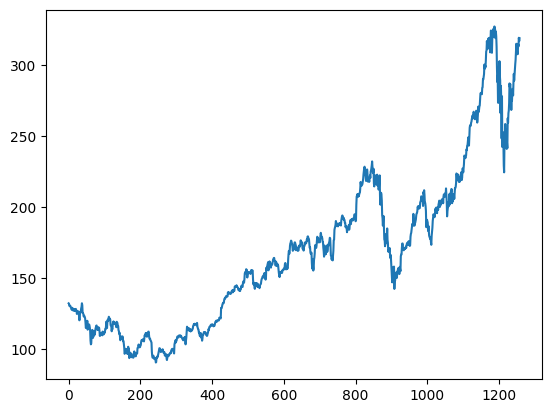

In [6]:
plt.plot(df1)

### Over the time we can see the there is a fluctuation in the data 

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(numpy.array(df1).reshape(-1,1))
df1[1:10]

array([[0.17495567],
       [0.16862282],
       [0.1696994 ],
       [0.16727181],
       [0.16794731],
       [0.16473866],
       [0.16174111],
       [0.1581525 ],
       [0.15654817]])

MinMax Scaler shrinks the data within the given range, usually of 0 to 1. It transforms data by scaling features to a given range. It scales the values to a specific value range without changing the shape of the original distribution

In case of time series data, the next data always depends on the previous data

# Spliting the data

In [8]:
training_size=int(len(df1)*0.65)
training_size

817

In [9]:
test_size=len(df1)-training_size
test_size

441

In [10]:
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
train_data[1:10]

array([[0.17495567],
       [0.16862282],
       [0.1696994 ],
       [0.16727181],
       [0.16794731],
       [0.16473866],
       [0.16174111],
       [0.1581525 ],
       [0.15654817]])

In [11]:
test_data[1:10]

array([[0.52837119],
       [0.53119986],
       [0.53871485],
       [0.5461454 ],
       [0.55999324],
       [0.56864815],
       [0.57962509],
       [0.58270708],
       [0.57641645]])

### Converting an array of values into a dataset matrix

In [12]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [],[]
    for i in range(len(dataset) - time_step-1):
        a = dataset[ i:(i+time_step),  0]
        b = dataset[ i + time_step,  0]
        dataX.append(a)
        dataY.append(b)
    return numpy.array(dataX), numpy.array(dataY)
        

In [13]:
time_step = 100

In [14]:
X_train, y_train = create_dataset(train_data, time_step)

In [15]:
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape)
print(y_train.shape)

(716, 100)
(716,)


### reshape input to be [samples, time steps, features] which is required for LSTM


In [17]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_train.shape

(716, 100, 1)

In [18]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_test.shape

(340, 100, 1)

# Stacked LSTM model 

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

**In simple term**


**return_sequences=False:** This is like following the recipe and only getting the final result, which is a plate of cookies. You don't see the intermediate steps

**return_sequences=True:** This is like following the recipe and taking a picture of the cookies after every step, from mixing the ingredients to placing each cookie on the tray. So, you get a sequence of pictures showing the progress, not just the final result. You can analyze each step along the way.


When **return_sequences=True** , LSTM produces the hidden state and cell state for every timestep in the input data, thus preserving the temporal relationships between the input timesteps.

**return_sequences to False**, the LSTM layer will **only return the output for the last time step in the sequence**.

**return_sequences to True**, the LSTM layer will return the **output for each time step in the input sequence**. This is useful when you want to use the LSTM's output at each time step or when you're building a sequence-to-sequence model.





In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 391ms/step - loss: 0.0150 - val_loss: 0.0640
Epoch 2/100
12/12 [==============================] - 3s 240ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 3/100
12/12 [==============================] - 3s 239ms/step - loss: 9.4522e-04 - val_loss: 0.0048
Epoch 4/100
12/12 [==============================] - 3s 240ms/step - loss: 8.0615e-04 - val_loss: 0.0038
Epoch 5/100
12/12 [==============================] - 3s 238ms/step - loss: 6.4782e-04 - val_loss: 0.0039
Epoch 6/100
12/12 [==============================] - 3s 241ms/step - loss: 6.1791e-04 - val_loss: 0.0040
Epoch 7/100
12/12 [==============================] - 3s 236ms/step - loss: 6.3336e-04 - val_loss: 0.0049
Epoch 8/100
12/12 [==============================] - 3s 244ms/step - loss: 6.3208e-04 - val_loss: 0.0044
Epoch 9/100
12/12 [==============================] - 3s 263ms/step - loss: 6.0785e-04 - val_loss: 0.0035
Epoch 10/100
12/12 [==============================] - 3s 236ms

# Prediction 

In [22]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 1s 51ms/step


### Calculate RMSE performance metrics


In [30]:
math.sqrt(mean_squared_error(y_train,train_predict)) *10000

124.032417424611

a common way to calculate RMSE when evaluating a regression model's performance.

it measures the average magnitude of errors between your model's predictions and the actual (true) values

In [31]:
math.sqrt(mean_squared_error(ytest,test_predict))*10000

588.7423851530851

# Plotting 

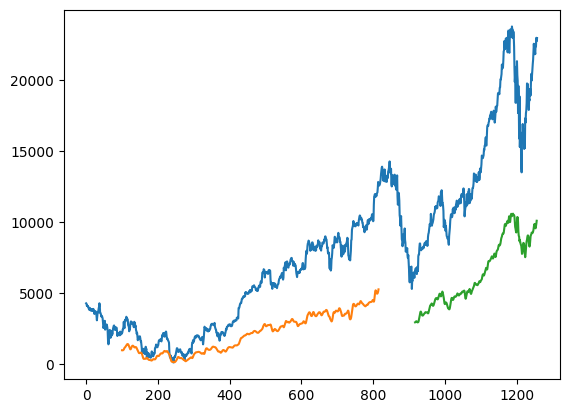

In [39]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1) 
trainPredictPlot[:, :] = numpy.nan 
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict*10000

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict*10000

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Predict the next 30days

In [40]:
len(test_data)

441

In [41]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [42]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [43]:
temp_input[1:10]

[0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415]

In [45]:
lst_output=[]
n_steps=100
i=0

In [48]:
while(i<30):
    
    if(len(temp_input)>100):
        x_input=numpy.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [49]:
print(lst_output[1:10])


[[1.0409832000732422], [1.0689475536346436], [1.0950088500976562], [1.1143560409545898], [1.1253219842910767], [1.128307819366455], [1.1254184246063232], [1.1200149059295654], [1.1159212589263916]]


In [51]:
day_new=numpy.arange(1,101)
day_pred=numpy.arange(101,131)

In [52]:
len(df1)

1258

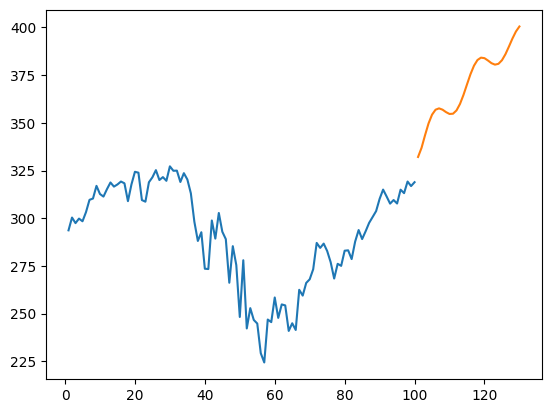

In [53]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))